[View in Colaboratory](https://colab.research.google.com/github/maxmatical/fast.ai/blob/master/fast_ai_lesson_2.ipynb)

# installing required libraries



In [0]:
# script for installing fastai and required libraries
# note: using pytoch 0.3.0, may have to change later
!apt-get -qq install -y libsm6 libxext6 && pip install -q -U opencv-python
import cv2
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.3.0.post4-{platform}-linux_x86_64.whl torchvision
import torch
!pip install Pillow==4.0.0
!pip install image
%matplotlib inline
!pip install fastai
!pip install pathlib
#from fastai.imports import *

In [2]:
# check for CUDA
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print('Torch', torch.__version__, 'CUDA', torch.version.cuda)

#print('Device:', torch.device('cuda:0'))


0.3.0.post4
True
Torch 0.3.0.post4 CUDA 8.0.61


In [0]:
# PIL workaround
!pip install Pillow==4.0.0
!pip install PIL
!pip install image

# loading data

http://forums.fast.ai/t/how-to-download-data-for-lesson-2-from-kaggle-for-planet-competition/7684

In [0]:
# creating a data directory (for cloud servers only, should have a data folder in working directory on computer)
!mkdir data

In [0]:
# download kaggle client

!pip install kaggle-cli --upgrade

In [0]:

!kg config -u m6tian -p iathgd1994 -c planet-understanding-the-amazon-from-space

In [0]:
!kg download

In [0]:
# extracting the tar files

!cd data # data directory


!7za x train-jpg.tar.7z
!7za x test-jpg.tar.7z
!7za x test-jpg-additional.tar.7z


In [0]:
!tar xf train-jpg.tar
!tar xf test-jpg.tar
!tar xf test-jpg-additional.tar

#!tar xf train-jpg.tar -d data/
#!tar xf test-jpg.tar -d data/
#!tar xf test-jpg-additional.tar -d data/


In [10]:
# extracting csv zip files
!unzip train_v2.csv.zip 
!unzip test_v2_file_mapping.csv.zip
!unzip sample_submission_v2.csv.zip

#!unzip train_v2.csv.zip -d data/
#!unzip test_v2_file_mapping.csv.zip -d data/
#!unzip sample_submission_v2.csv.zip -d data/

Archive:  train_v2.csv.zip
  inflating: train_v2.csv            
   creating: __MACOSX/
  inflating: __MACOSX/._train_v2.csv  
Archive:  test_v2_file_mapping.csv.zip
  inflating: test_v2_file_mapping.csv  
Archive:  sample_submission_v2.csv.zip
  inflating: sample_submission_v2.csv  
  inflating: __MACOSX/._sample_submission_v2.csv  


#visualize some data
    

In [11]:
# check the directory of the data 
!ls -d $PWD/*

/content/data				  /content/test-jpg.tar
/content/Kaggle-planet-test-tif.torrent   /content/test-jpg.tar.7z
/content/Kaggle-planet-train-tif.torrent  /content/test-tif-v2.tar.7z
/content/__MACOSX			  /content/test_v2_file_mapping.csv
/content/sample_data			  /content/test_v2_file_mapping.csv.zip
/content/sample_submission_v2.csv	  /content/train-jpg
/content/sample_submission_v2.csv.zip	  /content/train-jpg.tar
/content/test-jpg			  /content/train-jpg.tar.7z
/content/test-jpg-additional		  /content/train-tif-v2.tar.7z
/content/test-jpg-additional.tar	  /content/train_v2.csv
/content/test-jpg-additional.tar.7z	  /content/train_v2.csv.zip


In [0]:
from fastai.conv_learner import *
PATH = '/content/' # workaround to the path
os.makedirs(PATH,exist_ok=True)

In [13]:
!ls {PATH}

data				 test-jpg.tar
Kaggle-planet-test-tif.torrent	 test-jpg.tar.7z
Kaggle-planet-train-tif.torrent  test-tif-v2.tar.7z
__MACOSX			 test_v2_file_mapping.csv
sample_data			 test_v2_file_mapping.csv.zip
sample_submission_v2.csv	 train-jpg
sample_submission_v2.csv.zip	 train-jpg.tar
test-jpg			 train-jpg.tar.7z
test-jpg-additional		 train-tif-v2.tar.7z
test-jpg-additional.tar		 train_v2.csv
test-jpg-additional.tar.7z	 train_v2.csv.zip


In [0]:
from fastai.plots import *


In [15]:
files = !ls {PATH}/train-jpg | head
files

['train_0.jpg',
 'train_10000.jpg',
 'train_10001.jpg',
 'train_10002.jpg',
 'train_10003.jpg',
 'train_10004.jpg',
 'train_10005.jpg',
 'train_10006.jpg',
 'train_10007.jpg',
 'train_10008.jpg']

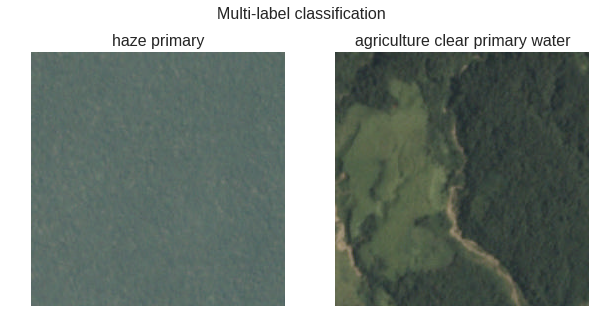

In [16]:
list_paths = [f"{PATH}train-jpg/train_0.jpg", f"{PATH}train-jpg/train_1.jpg"]
titles=["haze primary", "agriculture clear primary water"]
plots_from_files(list_paths, titles=titles, maintitle="Multi-label classification")

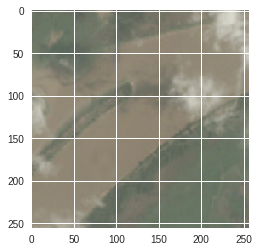

In [17]:
# plotting sample image
img = plt.imread(f"{PATH}train-jpg/train_27.jpg")
plt.imshow(img);

# Process
1.Enable data augmentation, and precompute=True

2.Use lr_find() to find highest learning rate where loss is still clearly improving

3.Train last layer from precomputed activations for 1-2 epochs

4.Train last layer with data augmentation (i.e. precompute=False) for 2-3 epochs with cycle_len=1 (replace with STLR)

5.Unfreeze all layers

6.Use lr_find() again

7.Set earlier layers to 3x-10x lower learning rate than next higher layer

8.Train full network with cycle_mult=2 until over-fitting (replace with STLR)

9.TTA

Note on transfer learning and increasing image size: only use increasing img size for images different from imagenet. Using image size trick might destroy pretrained weights when used on images similar to imagenet
however

*   However image size trick is very useful for non-imagenet images or training a model from scratch






# Defining base model, data, metrics

In [0]:
# importing models
from fastai.conv_learner import *

In [0]:
# transfer learning base model

base_model = resnet34 # using resnet, dont need to .CUDA() for pretrained models

In [0]:
# defining validation dataset
label_csv = f'{PATH}train_v2.csv'
n = len(list(open(label_csv)))-1
val_idxs = get_cv_idxs(n)

# defining transformations

def get_data(sz, bs):
    tfms = tfms_from_model(base_model, sz, aug_tfms=transforms_top_down, max_zoom=1.05)
    return ImageClassifierData.from_csv(PATH, 'train-jpg', label_csv, tfms=tfms,
                    suffix='.jpg', val_idxs=val_idxs, test_name='test-jpg', bs = bs)

# defining batch size and image size
bs=256

sz = 256

In [0]:
# importing f2 metric
from sklearn.metrics import fbeta_score

def f2(preds, targs, start=0.17, end=0.24, step=0.01):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        return max([fbeta_score(targs, (preds>th), 2, average='samples')
                    for th in np.arange(start,end,step)])

metrics=[f2]

#Model fitting with 64x64 size img

In [0]:
data = get_data(64, bs)

In [23]:
# multiply size by 1.3
data = data.resize(int(sz*1.3), 'tmp')

In [24]:
# create learn object
learn = ConvLearner.pretrained(base_model, data, precompute=True, metrics = metrics)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 48385147.88it/s]


100%|██████████| 159/159 [01:44<00:00,  4.14it/s]


epoch      trn_loss   val_loss   f2         
    0      0.426924   0.204901   0.846673  



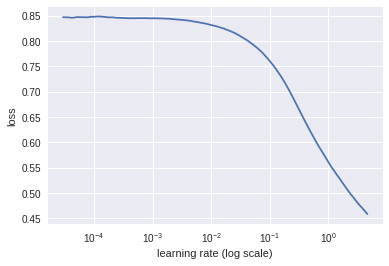

In [25]:
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
# learning rate maybe 0.2
lr = 0.2; wd=0

In [27]:
# fitting models for 1-2 epochs with precompute = True
%time learn.fit(lr, 2, wds = wd)

epoch      trn_loss   val_loss   f2         
    0      0.169202   0.137331   0.876281  
    1      0.140951   0.131067   0.883483  

CPU times: user 18.3 s, sys: 13.4 s, total: 31.7 s
Wall time: 21.7 s


[array([0.13107]), 0.8834829754349752]

In [28]:
# fitting model with data augmentation (precompute = False)
learn.precompute=False

%time learn.fit(lr, 3, wds = wd, cycle_len=1, cycle_mult= 2) #sgdr f2 = 0.8917
#%time learn.fit(lr, 1, cycle_len=20, use_clr=(20,10), wds = wd)  # f2 = 0.8959

epoch      trn_loss   val_loss   f2         
    0      0.138747   0.129548   0.884791  
    1      0.136789   0.127668   0.886926  
    2      0.134208   0.127278   0.887479  
    3      0.132957   0.12657    0.889132  
    4      0.131745   0.12524    0.890284  
    5      0.13113    0.124596   0.891101  
    6      0.130068   0.124684   0.890928  

CPU times: user 20min 31s, sys: 3min 12s, total: 23min 44s
Wall time: 12min 55s


[array([0.12468]), 0.8909275338368934]

epoch      trn_loss   val_loss   f2         
    0      0.166382   7.540881   0.068478  



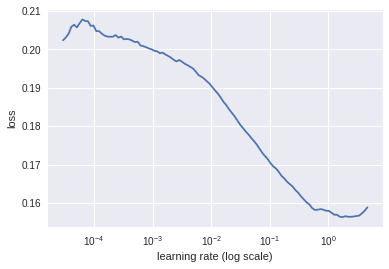

In [29]:
# unfreeze layers
learn.unfreeze()
# finding lr again
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
# set discriminative learning rates
# best lr appears to be 0.2-0.3 (LR is in log scale)
lr = 0.2
lr_d = np.array([lr/9, lr/3, lr]) # since images are not like imagenet, use 3x higher lr for each upper block

In [33]:
# fitting using LR scheduler
# note: sgdr seems to be better than sltr for image classification
#%time learn.fit(lr_d, 1, cycle_len = 20, wds = wd, use_clr=(20,10))  # cyclical learning rate Slanted triangular LR for 1 cycle (20 epochs)
%time learn.fit(lr_d, 3, wds = wd, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   f2         
    0      0.1264     0.115086   0.901751  
    1      0.114779   0.106442   0.91067   
    2      0.108744   0.104726   0.912901  
    3      0.107587   0.10357    0.912134  
    4      0.104786   0.101134   0.91615   
    5      0.101681   0.100212   0.915625  
    6      0.100516   0.100548   0.915486  

CPU times: user 31min 3s, sys: 4min 54s, total: 35min 58s
Wall time: 24min 8s


[array([0.10055]), 0.915485623206215]

In [0]:
# saving model
learn.save('64x64')

# Model fitting with 128x128 size img



In [0]:
# optional: loading previous model
# loading 64x64 model
learn.load('64x64')

In [0]:
# setting data
learn.set_data(get_data(128, bs))

In [0]:
# freezing conv layers again
learn.freeze()

epoch      trn_loss   val_loss   f2         
    0      0.106014   0.127593   0.903632  



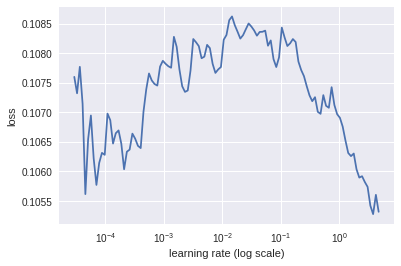

In [38]:
# finding lr again
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
# learning rate seems to be lr = 0.2
lr = 0.2

In [40]:
# train frozen network for 3 cycles
%time learn.fit(lr, 3, wds = wd, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   f2         
    0      0.102345   0.101614   0.912163  
    1      0.101445   0.099485   0.91474   
    2      0.09938    0.098923   0.91495   
    3      0.099921   0.09928    0.913075  
    4      0.098046   0.098595   0.914766  
    5      0.097312   0.097801   0.915918  
    6      0.096495   0.097817   0.915762  

CPU times: user 25min 57s, sys: 2min 22s, total: 28min 19s
Wall time: 16min 14s


[array([0.09782]), 0.9157616993236464]

In [0]:
# unfreeze layers
learn.unfreeze()

epoch      trn_loss   val_loss   f2         
    0      0.125664   6.165996   0.056847  



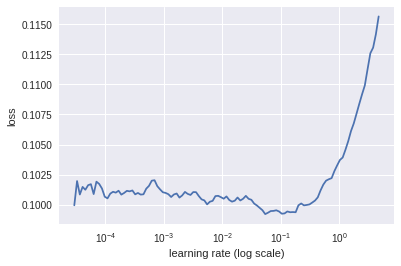

In [43]:
# finding lr again
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
# set discriminative learning rates
# best lr appears to be 0.03 
lr = 0.03
lr_d = np.array([lr/9, lr/3, lr]) # since images are not like imagenet, use 3x higher lr for each upper block

In [45]:
# fitting using LR scheduler
# note: sgdr seems to be better than sltr for image classification
#%time learn.fit(lr_d, 1, cycle_len = 20, wds = wd, use_clr=(20,10))  # cyclical learning rate Slanted triangular LR for 1 cycle (20 epochs)
%time learn.fit(lr_d, 3, wds = wd, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   f2         
    0      0.097988   0.095467   0.918237  
    1      0.094945   0.093316   0.920343  
    2      0.094905   0.092774   0.921142  
    3      0.094268   0.092298   0.920915  
    4      0.092994   0.091534   0.921366  
    5      0.092246   0.091792   0.920412  
    6      0.091686   0.091624   0.921241  

CPU times: user 43min 59s, sys: 7min 8s, total: 51min 8s
Wall time: 38min 36s


[array([0.09162]), 0.9212407820590948]

In [0]:
# saving model
learn.save('128x128')

# 256x256 img

In [0]:
#optional: loading model
learn.load('128x128')

In [0]:
# setting data
learn.set_data(get_data(sz, bs))

In [0]:
# freezing conv layers again
learn.freeze()

epoch      trn_loss   val_loss   f2         
    0      0.102234   0.136521   0.899686  



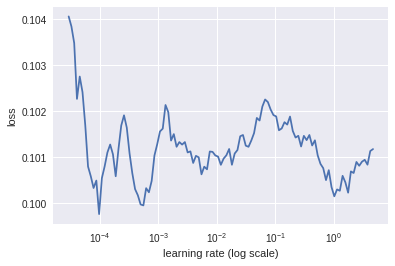

In [50]:
# finding lr again
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
#setting lr
lr = 0.2

In [52]:
# train frozen network for 3 cycles
%time learn.fit(lr, 3, wds = wd, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   f2         
    0      0.097335   0.095155   0.917968  
    1      0.096617   0.093329   0.919789  
    2      0.094549   0.092794   0.920254  
    3      0.094723   0.092126   0.922557  
    4      0.094196   0.091568   0.922028  
    5      0.092216   0.091278   0.921643  
    6      0.092133   0.091362   0.921418  

CPU times: user 1h 2min 3s, sys: 9min 10s, total: 1h 11min 13s
Wall time: 47min 25s


[array([0.09136]), 0.9214179787708775]

In [0]:
# unfreeze layers
learn.unfreeze()

epoch      trn_loss   val_loss   f2         
    0      0.124619   11.648493  0.529845  



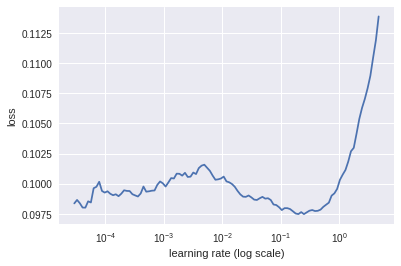

In [54]:
# finding lr again
lrf = learn.lr_find()
learn.sched.plot()

In [0]:
#setting lr_d
lr = 0.2
lr_d = np.array([lr/9, lr/3, lr])

In [57]:
# fitting using LR scheduler
# note: sgdr seems to be better than sltr for image classification
#%time learn.fit(lr_d, 1, cycle_len = 20, wds = wd, use_clr=(20,10))  # cyclical learning rate Slanted triangular LR for 1 cycle (20 epochs)
%time learn.fit(lr_d, 3, wds = wd, cycle_len=1, cycle_mult= 2)

epoch      trn_loss   val_loss   f2         
    0      0.093135   0.087984   0.925323  
    1      0.089309   0.087814   0.923476  
    2      0.086076   0.084827   0.927797  
    3      0.087253   0.086804   0.926567  
    4      0.086093   0.08419    0.927396  
    5      0.083013   0.083395   0.929187  
    6      0.081738   0.082891   0.929864  

CPU times: user 1h 34min 43s, sys: 32min 23s, total: 2h 7min 6s
Wall time: 1h 42min 44s


[array([0.08289]), 0.9298638432329684]

In [0]:
# saving model
learn.save('256x256')

# prediction and file submission

In [59]:
multi_preds, y = learn.TTA()
preds = np.mean(multi_preds, 0)

f2(preds,y)

0.9304660336788815